# General Instructions

Students are allowed to work on this exercise in pairs. Make sure you have formed a group in Canvas with your partner. Each student is responsible for following the [Code of Conduct](https://kth.instructure.com/courses/32018/pages/code-of-conduct). In particular (1) All members of a group are responsible for the group's work, (2) Every student shall honestly disclose any help received and sources used, and (3) Do not copy from other people's solutions.

If you need assistance with the exercise, you are encouraged to post a question to the appropriate [Discussion Topic](https://kth.instructure.com/courses/32018/discussion_topics) or sign up for a help session.

<br>

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and delete the `raise NotImplementedError()` once you have implemented the solution

<br>

You should not import any libraries on top of the ones included in the assignment. Derivation questions can be answered using $\LaTeX$, or you may upload an image of your derivation. To do so in *Google Colab* simply create a text cell, click on the `insert image` icon, and upload an image to the notebook as we have demonstrated below.

<br>

**Submission** - once you have completed the exercise make sure everything runs as expected by going into `Runtime` -> `Restart and Run all` then download the notebook by clicking `file` -> `download` -> `download .ipynb`. Then **rename the file to include your name** (and **your partner's name** if you have one) as follows

<br>

`Ex??_LASTNAME_FIRSTNAME_and_LASTNAME_FIRSTNAME.ipynb`

<br>

where you replace `??` with the correct exercise number. If you are working alone you do not need to include a partner name. Correctly naming the file and including your name (and your partner's) below is worth **1 point** - if you fail to correctly name the file or include your partner's name, *you will lose this point*.

<br>

Good luck!

# Name (1 pts)
**Fill in your name and your partner's name below** (and name the `.ipynb` file correctly): <font color="red"> (1 Point) </font>


Ruimin Ma

Kecheng Zhang

---

# Exercise 7: Machine learning and probability (26 points)

In this exercise, you will apply a vartiety density-estimation techniques to a number of problems in one or more dimensions. The excercise contains two parts:
1. One-dimensional problems with MLE, MAP, and KDE
2. A two-dimensional problem with GMMs

In [60]:
import random
import time

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from scipy.special import loggamma
from scipy.special import logsumexp

import os
import matplotlib.pyplot as plt
import numpy as np

from IPython import display


# Fixing the random seed for reproducibility
RANDOM_SEED=4321
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

%matplotlib inline

## 7.1 One-dimensional problems (19.5 points)

In this part of the exercise, you will perform density-estimation on three different datasets in one dimension. We will call these datasets dataset A, dataset B, and dataset C. All the data and distributions in this exercise are known to be nonnegative.

To analyse the data and to fit densities to it, you will use maximum likelihood, Bayesian methods (maximum a posteriori), and kernel density estimation. The problems include both hands-on coding and theoretical derivations.

### Loading the datasets

The below code downloads a JSON file with the datasets you need.

In [61]:
!curl https://gist.githubusercontent.com/shivammehta25/74b9d6f88462d59599a37a42597fac7c/raw/b0d4faec83395f3715256893da92033d8dffc7d3/assignment_6_data.json --output data.json

assert os.path.exists('data.json'), "Please download the data by running the cell above."

import json
with open('data.json') as data:
    data = json.load(data)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29403  100 29403    0     0   254k      0 --:--:-- --:--:-- --:--:--  256k


To get an idea of what the data looks like, first load the three different datasets into memory using the command `np.load`.

In [62]:
dataset = data['part_1']
for ds in dataset:
    # Note: Do not make changes to the structure of the datasets;
    #       just load the dataset into the keys.
    print("Dataset: " + str(ds))
    dataset[ds] = np.array(dataset[ds])
    print("Number of points: " + str(len(dataset[ds])))
#print(dataset['A'])
#print(dataset['B'])
#print(dataset['C'])

Dataset: A
Number of points: 100
Dataset: B
Number of points: 120
Dataset: C
Number of points: 1000


The `dataset` dictionary now contains 3 keys `[A, B, C]`, each of which will return the corresponding dataset `A`, `B` or `C`, respectively.

### Visualising the datasets

The first thing to do when dealing with a new dataset is to try to get an idea of what it looks like, and what is going on. One-dimensional data is generally quite easy to take in visually. Here's we'll start with a histogram, which is a very common visualisation in one dimension and can be seen as a (somewhat crude) density esttimation method.

**7.1.1 Task:**<br/>
Plot a histogram for each of the three datasets using the command `axes.hist`, using the parameter `density=True` to normalise them into a probability distribution.
For each dataset, play around with the number of bins until you think you have a histogram that you think gives a good picture of what is going on, and then include that plot below. <font color="red">(1 Point)</font>

_Hint:_<br/>
Since we know that these data come from nonnegative distributions, the horizontal axis in any of the one-dimensional plots in this exercise should not include negative numbers.

_Hint:_<br/>
Like many other plots in this part of the exercise, you will be returning to this visualisation later on. It can therefore be useful to store properties such as the number of bins in a variable, so that all histograms in your notebook change in synchrony in case you decided to change these properties later on.

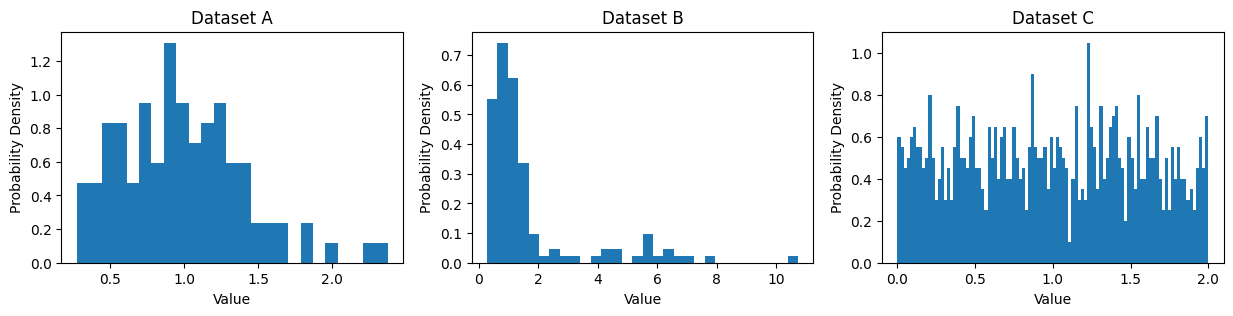

In [63]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
#这里的bin value是我瞎试的
# Hint: Use the axes ax1, ax2 and ax3 for plotting
ax1.set_title('Dataset A')
# YOUR CODE HERE
num_bins_A = 25
ax1.hist(dataset['A'], bins= num_bins_A, density=True)
ax1.set_xlabel('Value')
ax1.set_ylabel('Probability Density')

ax2.set_title('Dataset B')
# YOUR CODE HERE
num_bins_B = 30
ax2.hist(dataset['B'], bins= num_bins_B, density=True)
ax2.set_xlabel('Value')
ax2.set_ylabel('Probability Density')

ax3.set_title('Dataset C')
# YOUR CODE HERE
num_bins_C = 100
ax3.hist(dataset['C'], bins= num_bins_C, density=True)
ax3.set_xlabel('Value')
ax3.set_ylabel('Probability Density')

plt.show()

**7.1.2 Question:**
Do the datasets seem to come from a discrete or a continuous distribution? Write one or two sentences to motivate your answer. <font color="red">(0.5 Point)</font>

YOUR ANSWER HERE

They appear to come from continuous distributions. In the datasets there is (almost) no repeating data and at least for dataset A and B seems fit some continuous probability distribution we know.

### Kernel density estimation

Histograms are not good at capturing the actual shape of a distribution. To get a better idea of what the actual distributions look like, we can apply kernel density estimation instead. Let’s do that here.

**7.1.3 Task:**<br/>
Use `sklearn.neighbors.KernelDensity`, which has been imported for you, to estimate the density of each dataset. Let the kernels be `gaussian` (also known as the _squared exponential kernel_) and try to tune the bandwidth separately for each dataset to a value that you think gives the most accurate impression of the shape of the underlying distribution.
Do this by plotting and re-plotting each estimated density for a wide range of different bandwidth values, and home in on what you think looks the most accurate. Show the final plots, with your selected bandwidths, below. <font color="red">(1.5 Point)</font>

_Hint:_<br/>
Note that “giving the most accurate impression of the shape of the underlying distribution” is _not_ the same thing as “being as similar as possible to the histogram”. Histograms can be misleading.

_Hint:_<br/>
To help you get started, we have provided example code for how to use `sklearn.neighbors.KernelDensity`.
Since `sklearn.neighbors.KernelDensity` expects input of shape `(n_samples, n_features)`, the example code shows you how to add an extra dimension in NumPy using `data[:, np.newaxis]`. If you want additional information regarding the syntax for interacting with `sklearn.neighbors.KernelDensity`, the following tutorial might be useful: https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

_Hint:_<br/>
Like many other plots in this part of the exercise, you will be returning to this visualisation later on. It can therefore be useful to store important properties (such as the bandwidths, the $x$-values where the KDE is evaluated for each plot, and the values of the KDE pdf at these values) in dedicated variables, so that all KDEs in your notebook change in synchrony in case you decide to change these properties later on.

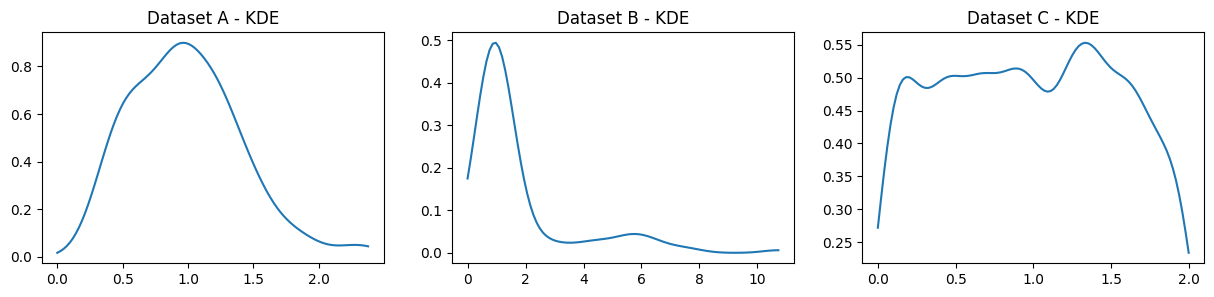

Bandwidth selected for dataset A: 0.1519911082952934
Bandwidth selected for dataset B: 0.533669923120631
Bandwidth selected for dataset C: 0.1


In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

ax1.set_title('Dataset A - KDE')
# Example code for making a KDE plot of dataset A (please overwrite the values):
#bandwidth_a = 0 # KDE bandwidth
#x_max_a = 0 # Biggest value shown on the horizontal axis
# YOUR CODE HERE
bandwidth_a =  0.1519911082952934
x_max_a = np.max(dataset['A'])
kde = KernelDensity(bandwidth=bandwidth_a, kernel='gaussian')
kde.fit(dataset['A'][:, None])
x_a = np.linspace(0, x_max_a, 100)[:, None]
logprob = kde.score_samples(x_a) # score_samples returns the log of the probability density
kde_pdf_a = np.exp(logprob)
ax1.plot(x_a, kde_pdf_a)

# Now you do the same for datasets B and C!

ax2.set_title('Dataset B - KDE')
# YOUR CODE HERE
bandwidth_b = 0.533669923120631
x_max_b = np.max(dataset['B'])
kde = KernelDensity(bandwidth=bandwidth_b, kernel='gaussian')
kde.fit(dataset['B'][:, None])
x_b = np.linspace(0, x_max_b, 100)[:, None]
logprob = kde.score_samples(x_b) # score_samples returns the log of the probability density
kde_pdf_b = np.exp(logprob)
ax2.plot(x_b, kde_pdf_b)

ax3.set_title('Dataset C - KDE')
# YOUR CODE HERE
bandwidth_c = 0.1
x_max_c = np.max(dataset['C'])
kde = KernelDensity(bandwidth=bandwidth_c, kernel='gaussian')
kde.fit(dataset['C'][:, None])
x_c = np.linspace(0, x_max_c, 100)[:, None]
logprob = kde.score_samples(x_c) # score_samples returns the log of the probability density
kde_pdf_c = np.exp(logprob)
ax3.plot(x_c, kde_pdf_c)

plt.show()

# Print the bandwidths you chose for the different datasets here
print("Bandwidth selected for dataset A: " + str(bandwidth_a))
print("Bandwidth selected for dataset B: " + str(bandwidth_b))
print("Bandwidth selected for dataset C: " + str(bandwidth_c))

**7.1.4 Task:**<br/>
To illustrate the effect of small and wide bandwidths, repeat your previous plots for all three datasets, but with the KDE bandwidth set to $\frac{1}{5}$ and $5$ times the value you chose for each dataset. Superimpose the resulting estimated densities on top of the ones in the three plots above, so that the densities are easy to compare.

Put another way, your task is to make the KDE bandwith artificially narrow for each dataset, and plot the KDE that results from that on top of the corresponding density plot from the previous cell. Then make another set of three plots, same as the previous ones except that you use an artificially wide bandwidth instead of an artificially narrow one. <font color="red">(0.5 Point)</font>

_Hint:_<br/>
This should be straightforward if you saved the necessary bandwidths, $x$-values, and KDE pdf values for the previous plots.

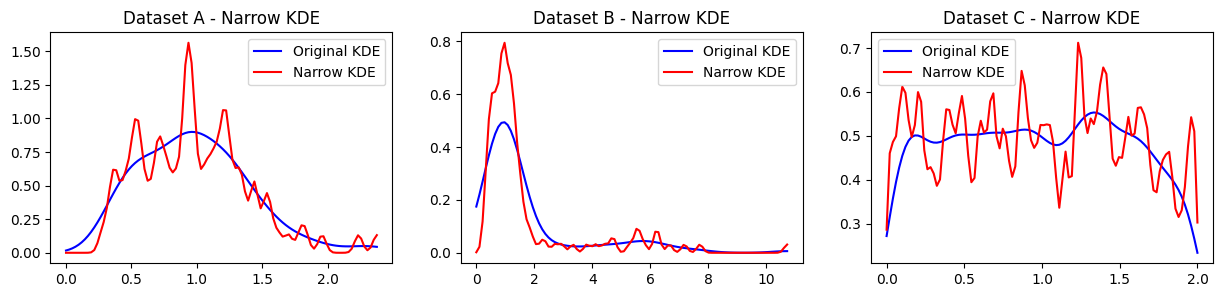

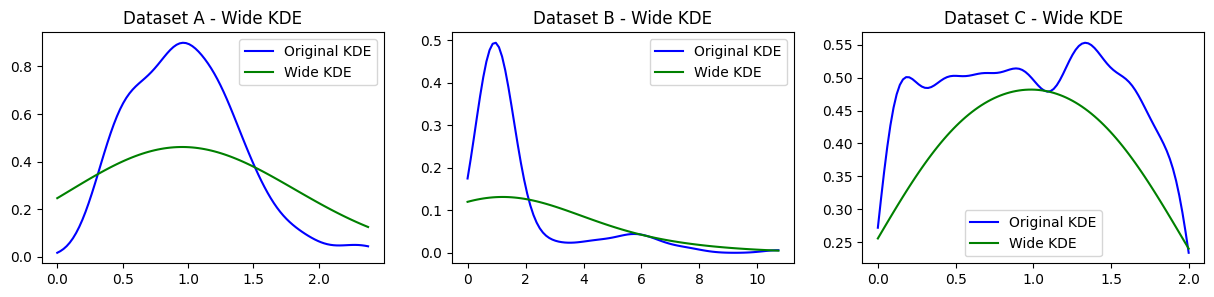

In [65]:
# Repeat the previous plots, but using 1/5 times your chosen bandwidth, overlaid on your original KDE

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

ax1.set_title('Dataset A - Narrow KDE')
# YOUR CODE HERE
ax1.plot(x_a, kde_pdf_a, label='Original KDE', color='blue')
# Calculate the KDE with a narrower bandwidth (1/5 times original bandwidth)
narrow_bandwidth_a = bandwidth_a / 5
kde_narrow_a = KernelDensity(bandwidth=narrow_bandwidth_a, kernel='gaussian')
kde_narrow_a.fit(dataset['A'][:, np.newaxis])
logprob_narrow_a = kde_narrow_a.score_samples(x_a)
kde_pdf_narrow_a = np.exp(logprob_narrow_a)
ax1.plot(x_a, kde_pdf_narrow_a, label='Narrow KDE', color='red')
ax1.legend()


ax2.set_title('Dataset B - Narrow KDE')
# YOUR CODE HERE
ax2.plot(x_b, kde_pdf_b, label='Original KDE', color='blue')
# Calculate the KDE with a wider bandwidth (1/5 times original bandwidth)
narrow_bandwidth_b = bandwidth_b / 5
kde_narrow_b = KernelDensity(bandwidth=narrow_bandwidth_b, kernel='gaussian')
kde_narrow_b.fit(dataset['B'][:, np.newaxis])
logprob_narrow_b = kde_narrow_b.score_samples(x_b)
kde_pdf_narrow_b = np.exp(logprob_narrow_b)
ax2.plot(x_b, kde_pdf_narrow_b, label='Narrow KDE', color='red')
ax2.legend()

ax3.set_title('Dataset C - Narrow KDE')
# YOUR CODE HERE
ax3.plot(x_c, kde_pdf_c, label='Original KDE', color='blue')
# Calculate the KDE with a wider bandwidth (1/5 times original bandwidth)
narrow_bandwidth_c = bandwidth_c / 5
kde_narrow_c = KernelDensity(bandwidth=narrow_bandwidth_c, kernel='gaussian')
kde_narrow_c.fit(dataset['C'][:, np.newaxis])
logprob_narrow_c = kde_narrow_c.score_samples(x_c)
kde_pdf_narrow_c = np.exp(logprob_narrow_c)
ax3.plot(x_c, kde_pdf_narrow_c, label='Narrow KDE', color='red')
ax3.legend()

plt.show()

# Then repeat the previous plots again, but using 5 times your chosen bandwidth overlaid on your original KDE

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

ax1.set_title('Dataset A - Wide KDE')
# YOUR CODE HERE
ax1.plot(x_a, kde_pdf_a, label='Original KDE', color='blue')
# Calculate the KDE with a wider bandwidth (5 times original bandwidth)
wide_bandwidth_a = bandwidth_a * 5
kde_wide_a = KernelDensity(bandwidth=wide_bandwidth_a, kernel='gaussian')
kde_wide_a.fit(dataset['A'][:, np.newaxis])
logprob_wide_a = kde_wide_a.score_samples(x_a)
kde_pdf_wide_a = np.exp(logprob_wide_a)
ax1.plot(x_a, kde_pdf_wide_a, label='Wide KDE', color='green')
ax1.legend()

ax2.set_title('Dataset B - Wide KDE')
# YOUR CODE HERE
ax2.plot(x_b, kde_pdf_b, label='Original KDE', color='blue')
# Calculate the KDE with a wider bandwidth (5 times original bandwidth)
wide_bandwidth_b = bandwidth_b * 5
kde_wide_b = KernelDensity(bandwidth=wide_bandwidth_b, kernel='gaussian')
kde_wide_b.fit(dataset['B'][:, np.newaxis])
logprob_wide_b = kde_wide_b.score_samples(x_b)
kde_pdf_wide_b = np.exp(logprob_wide_b)
ax2.plot(x_b, kde_pdf_wide_b, label='Wide KDE', color='green')
ax2.legend()

ax3.set_title('Dataset C - Wide KDE')
# YOUR CODE HERE
ax3.plot(x_c, kde_pdf_c, label='Original KDE', color='blue')
# Calculate the KDE with a wider bandwidth (5 times original bandwidth)
wide_bandwidth_c = bandwidth_c * 5
kde_wide_c = KernelDensity(bandwidth=wide_bandwidth_c, kernel='gaussian')
kde_wide_c.fit(dataset['C'][:, np.newaxis])
logprob_wide_c = kde_wide_c.score_samples(x_c)
kde_pdf_wide_c = np.exp(logprob_wide_c)
ax3.plot(x_c, kde_pdf_wide_c, label='Wide KDE', color='green')
ax3.legend()

plt.show()

**7.1.5 Question:**
Comment on how the KDE behaves when the bandwidth is too small, and when the bandwidth is too large. What changes do you see? <font color="red">(0.5 Point)</font>

YOUR ANSWER HERE

When the bandwidth is too small, KDE becomes too sensitive to every data change. It looks like high-frequency oscillation and over-fitting. KDE is too smooth when the bandwidth is too large. This results in a graph that is too broad and cannot capture local changes in the data.

There are several simple rules of thumb that can be used to set the kernel bandwidths automatically. However, all of them rely on quite specific assumptions, and often give misleading results when those assumptions are violated. They should therefore be used with caution. (A better, but more complicated approach is to use cross-validation.)

The simplest bandwidth-estimation formula based on mathematical principles is perhaps to choose the bandwidth $h$ as $$\widehat{h}=1.06\widehat{\sigma}n^{-\frac{1}{5}}$$ where n is the number of datapoints and $\widehat{\sigma}$ is the standard deviation of the data. This rule is optimal in a certain mathematically sense if the underlying distribution is a 1D Gaussian. Of course, that’s not always helpful, since if the data was Gaussian – and we knew that – we would not be using KDE to begin with. Nonetheless, the rule of thumb offers a place to start.

**7.1.6 Task:**<br/>
Apply the above rule of thumb to the three datasets. Overlay the resulting density estimates on top of the original density estimates for your selected bandwidths `bandwidth_a`, `bandwidth_b`, and `bandwidth_c` earlier. <font color="red">(0.75 Point)</font>

**7.1.7 Question:**<br/>
Write a comment in the code stating whether or not the shape of the latest density estimates agrees with the shapes of your original density estimates? <font color="red">(0.25 Point)</font>

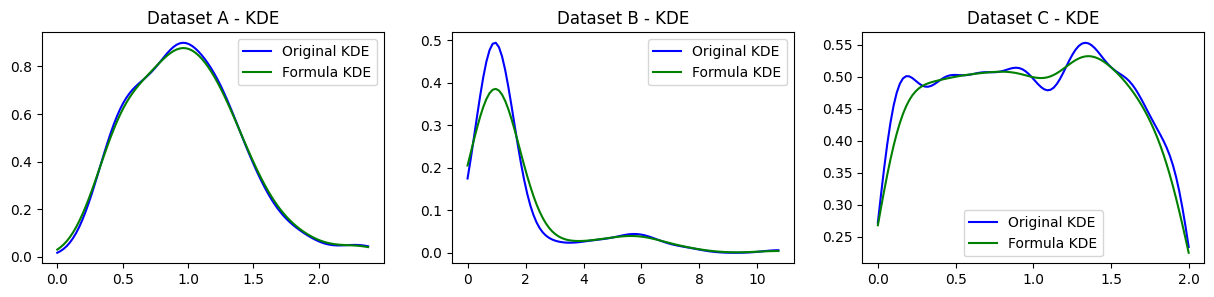

KL Divergence for Dataset A: 0.04230804442742862
KL Divergence for Dataset B: 0.1877378410444859
KL Divergence for Dataset C: 0.048902347441964006


In [66]:
# Based on formula
from scipy.special import kl_div

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

ax1.set_title('Dataset A - KDE')
# YOUR CODE HERE
ax1.plot(x_a, kde_pdf_a, label='Original KDE', color='blue')
bandwidth_formula_a = 1.06 * np.std(dataset['A']) * (len(dataset['A']))**(-1/5)
kde_formula_a = KernelDensity(bandwidth=bandwidth_formula_a, kernel='gaussian')
kde_formula_a.fit(dataset['A'][:, np.newaxis])
logprob_formula_a = kde_formula_a.score_samples(x_a)
kde_pdf_formula_a = np.exp(logprob_formula_a)
ax1.plot(x_a, kde_pdf_formula_a, label='Formula KDE', color='green')
ax1.legend()

ax2.set_title('Dataset B - KDE')
# YOUR CODE HERE
ax2.plot(x_b, kde_pdf_b, label='Original KDE', color='blue')
bandwidth_formula_b = 1.06 * np.std(dataset['B']) * (len(dataset['B']))**(-1/5)
kde_formula_b = KernelDensity(bandwidth=bandwidth_formula_b, kernel='gaussian')
kde_formula_b.fit(dataset['B'][:, np.newaxis])
logprob_formula_b = kde_formula_b.score_samples(x_b)
kde_pdf_formula_b = np.exp(logprob_formula_b)
ax2.plot(x_b, kde_pdf_formula_b, label='Formula KDE', color='green')
ax2.legend()

ax3.set_title('Dataset C - KDE')
# YOUR CODE HERE
ax3.plot(x_c, kde_pdf_c, label='Original KDE', color='blue')
bandwidth_formula_c = 1.06 * np.std(dataset['C']) * (len(dataset['C']))**(-1/5)
kde_formula_c = KernelDensity(bandwidth=bandwidth_formula_c, kernel='gaussian')
kde_formula_c.fit(dataset['C'][:, np.newaxis])
logprob_formula_c = kde_formula_c.score_samples(x_c)
kde_pdf_formula_c = np.exp(logprob_formula_c)
ax3.plot(x_c, kde_pdf_formula_c, label='Formula KDE', color='green')
ax3.legend()

plt.show()

# How similar are the distribution shapes to the shapes you found on your own?
# YOUR CODE HERE
# The shape of the latest density estimate is inconsistent with the shape of the original density estimate, there is a slight difference.
kl_a = np.sum(kl_div(kde_pdf_a, kde_pdf_formula_a))
kl_b = np.sum(kl_div(kde_pdf_b, kde_pdf_formula_b))
kl_c = np.sum(kl_div(kde_pdf_c, kde_pdf_formula_c))

print("KL Divergence for Dataset A:", kl_a)
print("KL Divergence for Dataset B:", kl_b)
print("KL Divergence for Dataset C:", kl_c)

### Maximum likelihood estimation

Thus far, we have seen a few things:
* The distribution of dataset A is a bit like a blob, with a longer tail towards the right than towards the left, compared to where the peak is. We say that the data (and its distribution) are _skewed to the right_.
* Dataset B has a similar distribution to A, except that there are some extra points with much higher values than before.
* Dataset C is not as skewed, and rather looks quite flat and doesn't appear to have much of a tail.

Now we will take this a bit further, to see what happens if we fit a parametric family to this data using maximum likelihood. In this exercise, you will use the gamma distribution, which is a scalar, continuous-valued, nonnegative distribution with two parameters. Its probability density function is defined by

$$\text{Gamma}(x;\alpha,\beta) := \frac{\beta^\alpha}{ \Gamma(\alpha)} x^{\alpha-1} \exp (-\beta x)$$

for $\text x\geq 0$, where $\alpha>0$ is the _shape parameter_ (which, surprise surprise, affects the overall shape of the disctribution) while $\beta>0$ is the _rate parameter_ (which does not affect the shape of the distribution at all, but only stretches or compresses it). The _gamma function_ $\Gamma(\alpha)$ in the denominator of the normalisation constant is an extension of the factorial. You can read more about it on Wikipedia: https://en.wikipedia.org/wiki/Gamma_function

Let's first implement the probability density function of the gamma distribution based on the formula shown above.

**7.1.8 Task:**<br/>
Implement the `pdf` function for the `Gamma` class below. <font color="red">(1.5 Point)</font>

_Hint:_<br/>
This is much more numerically stable if you do all computations in logarithmic space, and then apply `np.exp` as the very last step when you return the value of the function.

_Hint:_<br/>
Use `loggamma` already imported from `scipy.special.loggamma` when needed for computing the value of $\ln \Gamma \left(x\right)$.

_Note:_<br/>
If your implementation is correct, you might still get a harmless warning `RuntimeWarning: divide by zero encountered in log` whenever you evaluate the `pdf`function on $x=0$.

In [67]:
class Gamma:

    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta

    def pdf(self, x):
        """
        Defines the probability distribution function of the gamma distribution
        Remember Probability density function's value at some specific point does not give you probability;
        It is a measure of how dense the distribution is around that value.

        Args:
            x (np.ndarray): input data points
        Returns:
            pdf (np.ndarray): density of the input data points
        """
        if not isinstance(x, np.ndarray):
            x = np.array(x)

        # YOUR CODE HERE
        log_pdf = ((self.alpha - 1) * np.log(x) - self.beta * x - loggamma(self.alpha) + self.alpha * np.log(self.beta))
        pdf = np.exp(log_pdf)
        return pdf

In [68]:
assert np.isclose(Gamma(2, 0.2).pdf([1, 4, 5]), np.array([0.03274923, 0.07189263, 0.07357589])).all(), "Look at the formula again, make sure you parameterised the gamma distribution correctly"
assert np.isclose(Gamma(3, 1).pdf([1, 4, 5]), np.array([0.18393972, 0.14652511, 0.08422434])).all(), "Look at the formula again, make sure you parameterised the gamma distribution correctly"
assert np.isclose(Gamma(500, 100).pdf([4, 5, 6]), np.array([2.10234691e-05, 1.78382679e+00, 2.15449886e-04])).all(), "Make sure you perform all computations in logarithmic space until the very end"

For the rest of the exercise, we will keep the shape parameter fixed at $\alpha=5$ and only consider estimating $\beta$.

**7.1.9 Task:**<br/>
To get an idea of how this density behaves, make a plot of this distribution for a number of different $\beta$-values, say 1, 2, and 3. Use the `pdf` function that you defined above for the plots. <font color="red">(0.5 Point)</font>

If you like, you can play around with the shape parameter $\alpha$ to see what it does, but don't forget to set it back to 5 when you are done!

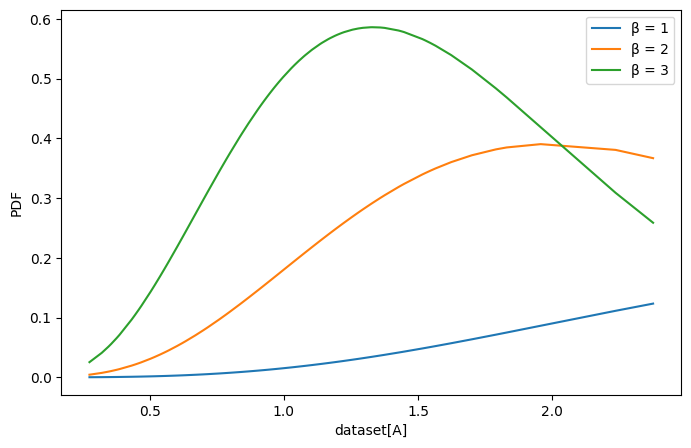

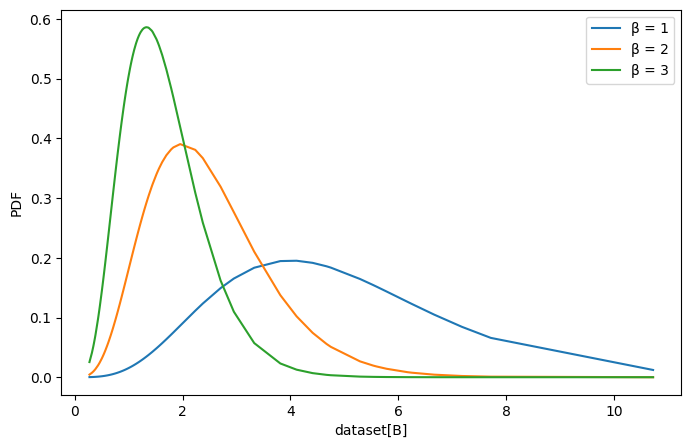

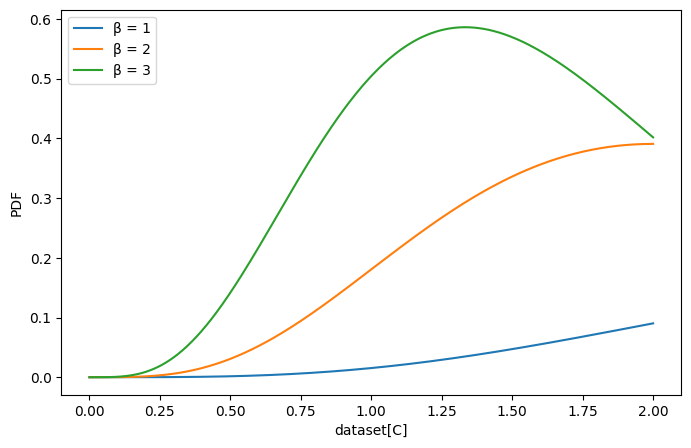

In [69]:
alpha = 5

# YOUR CODE HERE
beta = [1, 2, 3]
x = sorted(dataset['A'])
#x = dataset['A']

fig, ax1 = plt.subplots(figsize=(8, 5))

for b in beta:
    gamma_dist = Gamma(alpha, b)
    pdf_values = gamma_dist.pdf(x)
    ax1.plot(x, pdf_values, label = f'β = {b}')

# Set plot labels and legend
ax1.set_xlabel('dataset[A]')
ax1.set_ylabel('PDF')
ax1.legend()


#B
x = sorted(dataset['B'])
fig, ax2 = plt.subplots(figsize=(8, 5))

for b in beta:
    gamma_dist = Gamma(alpha, b)
    pdf_values = gamma_dist.pdf(x)
    ax2.plot(x, pdf_values, label = f'β = {b}')

# Set plot labels and legend
ax2.set_xlabel('dataset[B]')
ax2.set_ylabel('PDF')
ax2.legend()

#C
x = sorted(dataset['C'])
fig, ax3 = plt.subplots(figsize=(8, 5))

for b in beta:
    gamma_dist = Gamma(alpha, b)
    pdf_values = gamma_dist.pdf(x)
    ax3.plot(x, pdf_values, label = f'β = {b}')

# Set plot labels and legend
ax3.set_xlabel('dataset[C]')
ax3.set_ylabel('PDF')
ax3.legend()

plt.show()

**7.1.10 Question:**<br/>
Looking at the shape, do you think this distribution is a good fit for dataset A, B, and C, respectively? Give one or two sentences of motivation. <font color="red">(0.5 Point)</font>

YOUR ANSWER HERE

Yes, the gamma distribution is generally suitable for data that is positively skewed, meaning that most data points are concentrated on the left side of the distribution, while there is a long tail on the right side. This situation is more pronounced in datasets A and B, so the gamma distribution is a suitable choice.

However, dataset C is not a good fit for the gamma distribution because its data distribution is not right-skewed like A and B. The gamma distribution may not fit the data well in this case. You may want to consider other distributions or modeling methods to better describe data set C.

Regardless of your answer(s) to the previous question, we’re going to plow ahead, just see what happens when we apply maximum-likelihood parameter estimation to fit a gamma distribution to the three datasets. To do this, you will first derive a general formula for estimating $\beta$ from observations.

**7.1.11 Task:**<br/>
Let the data be $\mathcal{X}=\{x_i\}_{i=1}^n$. Derive the log likelihood of the data as a function of $\beta$. Show the derivation and the final formula below. <font color="red">(1.5 Point)</font>

YOUR ANSWER HERE
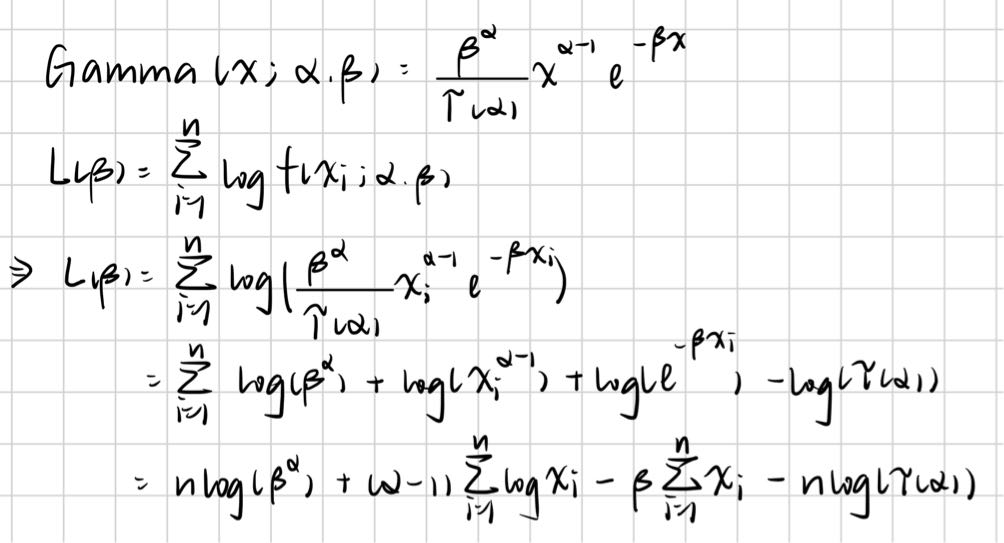

**7.1.12 Task:**<br/>
Plot the log-likelihood function you just derived for the case of dataset A over the range $\beta\in[0.5, 15]$. <font color="red">(0.5 Point)</font>

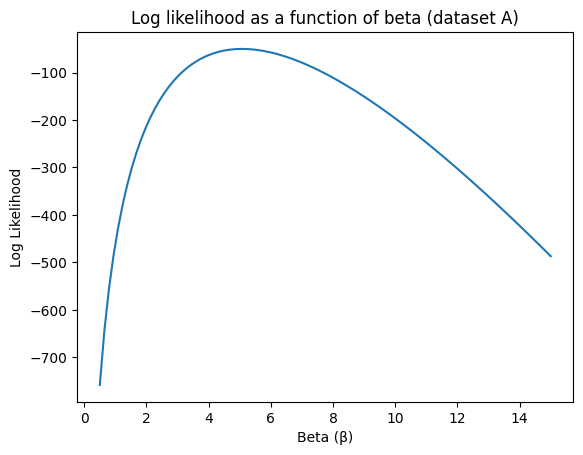

In [70]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Log likelihood as a function of beta (dataset A)')

# YOUR CODE HERE
beta_values = np.linspace(0.5, 15, 100)
log_likelihood_values = []
for beta in beta_values:
    log_likelihood = len(dataset['A']) * alpha * np.log(beta) + (alpha - 1) * np.sum(np.log(dataset['A'])) - beta * np.sum(dataset['A']) - len(dataset['A']) * np.log(np.math.gamma(alpha))
    log_likelihood_values.append(log_likelihood)
ax.set_title('Log likelihood as a function of beta (dataset A)')
ax.plot(beta_values, log_likelihood_values)
ax.set_xlabel('Beta (β)')
ax.set_ylabel('Log Likelihood')
plt.show()

**7.1.13 Task:**<br/>
Next, derive a formula for the maximum likelihood estimate $\widehat{\beta}_{\mathrm{ML}}$ as a function of the data $\mathcal{X}$ and the shape parameter $\alpha$. Show your work and the final formula below. <font color="red">(1.5 Point)</font>

YOUR ANSWER HERE
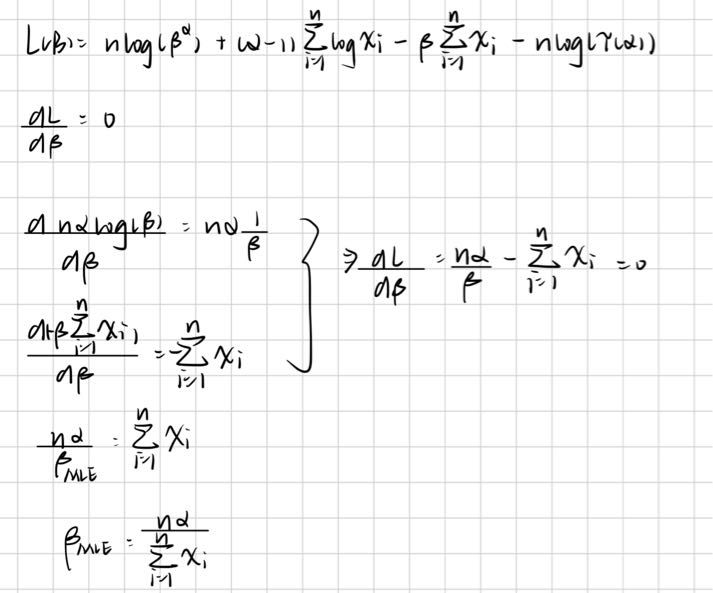

**7.1.14 Task:**<br/>
Write a small function that computes the maximum-likelihood estimate, based on the previously defined variable `alpha` and on the input `dataset`. <font color="red">(0.25 Point)</font>

In [71]:
def beta_hat_ml(dataset):
    # YOUR CODE HERE
    beta_ML = len(dataset)*alpha / np.sum(dataset)
    return beta_ML

In [72]:
assert np.isclose(beta_hat_ml([1, 2, 3, 4, 5]), 1.66666, atol=1e-4), "Make sure that alpha is set to 5"
assert np.isclose(beta_hat_ml([6.5, 7.5, 8.5, 9.5, 10.5]), 0.5882, atol=1e-4), "Check the formula and derivation again"

**7.1.15 Task:**<br/>
Apply the MLE function that you implemented to datasets A, B, and C. Plot the histograms and your prefered kernel density estimates from before, but with the respective maximum-likelihood estimated probability density function overlaid as a line plot. That is, each (sub)plot should contain three things: a histogram (like you plotted earlier in the exercise), a KDE (also from earlier in the exercise), and your new, ML-estimated gamma density function. <font color="red">(1 Point)</font>

_Hint:_<br/>
This should be straightforward if you saved the necessary histogram parameters, KDE bandwidths, $x$-values, and KDE pdf values from the previous plots.

<ipython-input-67-f7e903026ea9>:22: RuntimeWarning: divide by zero encountered in log
  log_pdf = ((self.alpha - 1) * np.log(x) - self.beta * x - loggamma(self.alpha) + self.alpha * np.log(self.beta))


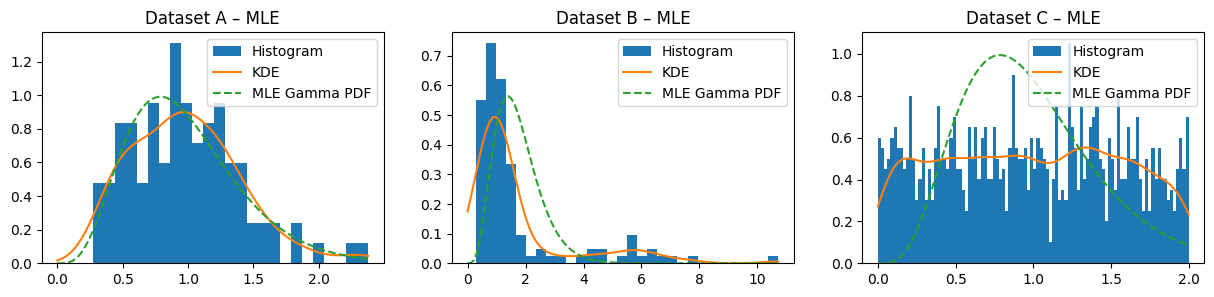

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

# Hint: Use the axes ax1, ax2 and ax3 for plotting
ax1.set_title('Dataset A – MLE')
# YOUR CODE HERE
beta_A_mle = beta_hat_ml(dataset['A'])
ax1.set_title('Dataset A – MLE')
hist_values_A, bins_A, _ = ax1.hist(dataset['A'], bins=num_bins_A, density=True, label='Histogram')
x_A = np.linspace(0, np.max(dataset['A']), 100)
kde_values_A = kde_pdf_a
ax1.plot(x_A, kde_values_A, label='KDE')

gamma_pdf_mle_A = Gamma(alpha, beta_A_mle).pdf(x_A)
ax1.plot(x_A, gamma_pdf_mle_A, label='MLE Gamma PDF', linestyle='--')
ax1.legend()

ax2.set_title('Dataset B – MLE')
# YOUR CODE HERE
beta_B_mle = beta_hat_ml(dataset['B'])
ax2.set_title('Dataset B – MLE')
hist_values_B, bins_B, _ = ax2.hist(dataset['B'], bins=num_bins_B, density=True, label='Histogram')
x_B = np.linspace(0, np.max(dataset['B']), 100)
kde_values_B = kde_pdf_b
ax2.plot(x_B, kde_values_B, label='KDE')
gamma_pdf_mle_B = Gamma(alpha, beta_B_mle).pdf(x_B)
ax2.plot(x_B, gamma_pdf_mle_B, label='MLE Gamma PDF', linestyle='--')
ax2.legend()

ax3.set_title('Dataset C – MLE')
# YOUR CODE HERE
beta_C_mle = beta_hat_ml(dataset['C'])
ax3.set_title('Dataset C – MLE')
hist_values, bins, _ = ax3.hist(dataset['C'], bins=num_bins_C, density=True, label='Histogram')
x_C = np.linspace(0, np.max(dataset['C']), 100)
ax3.plot(x_C, kde_pdf_c, label='KDE')
gamma_pdf_mle_C = Gamma(alpha, beta_C_mle).pdf(x_C)
ax3.plot(x_C, gamma_pdf_mle_C, label='MLE Gamma PDF', linestyle='--')
ax3.legend()

plt.show()

Let's compare datasets A and B by computing the following.

**7.1.16 Task:**<br/>
You might not have noticed this, but many of the datapoints (i.e., the $x$ values) in dataset B are also in dataset A. Compute how many of the datapoints in B that are not in A. <font color="red">(0.5 Point)</font>

**7.1.17 Task:**<br/>
How much do the values of $\widehat{\beta}_{\mathrm{ML}}$ differ between the two datasets? Compute and print the two beta values and their difference. <font color="red">(0.5 Point)</font>

In [74]:
# YOUR CODE HERE
data_points_not_in_A = set(dataset['B']) - set(dataset['A'])
#print(len(dataset['B']))
#print(len(set(dataset['B'])))
count_data_points_not_in_A = len(data_points_not_in_A)
print("Number of data points in B that are not in A:", count_data_points_not_in_A)

# YOUR CODE HERE
beta_difference = abs(beta_hat_ml(dataset['A']) - beta_hat_ml(dataset['B']))
print("Beta MLE for dataset A", beta_hat_ml(dataset['A']))
print("Beta MLE for dataset B", beta_hat_ml(dataset['B']))
print("Absolute difference between Beta MLE for datasets A and B:", beta_difference)

Number of data points in B that are not in A: 20
Beta MLE for dataset A 5.071930175574214
Beta MLE for dataset B 2.88429936319156
Absolute difference between Beta MLE for datasets A and B: 2.187630812382654


Interesting that so few datapoints can make such a big difference, huh? A lot of this can be explained as an effect of misspecification, as discussed in the module.

### Maximum a posteriori

Next up, we'll compare the maximum-likelihood estimate to a Bayesian approach. To do this, we need a prior distribution that represents our prior belief about how probable different values of $\boldsymbol\beta$ are. (Note that $\boldsymbol\beta$ now is a random variable.) We will use another gamma distribution for the prior density of $\boldsymbol\beta$. This prior will have parameters $a>0$ and $b>0$:

$$ \text{Gamma}(\beta;a,b) = \frac{b^a \beta^{a-1} \exp \left(-b\beta \right)}{\Gamma(a)} $$

**7.1.18 Task:**<br/>
Plot this density over the range $[0,12]$ using $a=5$ and $b=1$, $a=50$ and $b=10$, and $a=500$ and $b=100$. <font color="red">(0.5 Point)</font>

_Note:_<br/>
If your implementation of the `pdf` function does not use logarithmic space correctly for numerical safety, the final plot will fail.

<ipython-input-67-f7e903026ea9>:22: RuntimeWarning: divide by zero encountered in log
  log_pdf = ((self.alpha - 1) * np.log(x) - self.beta * x - loggamma(self.alpha) + self.alpha * np.log(self.beta))


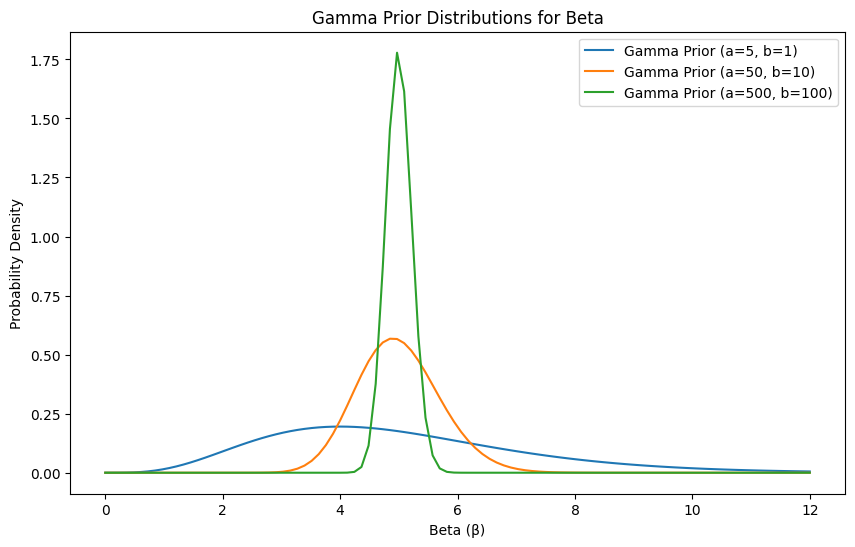

In [75]:
a_b_list = [(5, 1), (50, 10), (500, 100)]
# YOUR CODE HERE
beta_values = np.linspace(0, 12, 100)
fig, ax = plt.subplots(figsize=(10, 6))
for a, b in a_b_list:
    gamma_pdf = Gamma(a, b).pdf(beta_values)
    ax.plot(beta_values, gamma_pdf, label=f'Gamma Prior (a={a}, b={b})')
ax.set_title('Gamma Prior Distributions for Beta')
ax.set_xlabel('Beta (β)')
ax.set_ylabel('Probability Density')
ax.legend()
plt.show()

You might notice that the distribution stays in approximately the same place, but concentrates on a narrower interval as the values of the arguments increase.

**7.1.19 Task:**<br/>
Using the formula for the gamma prior, derive a closed-form expression for the maximum a posteriori estimate $\widehat{\beta}_{\mathrm{MAP}}$. Show the steps of the derivation and the final formula below. <font color="red">(3 Point)</font>

_Hint:_<br/>
The answer will be a function of the observations $x_i$ in the dataset $\mathcal{X}$ and also $a$ and $b$. Work in the log space, like for the MLE.

YOUR ANSWER HERE
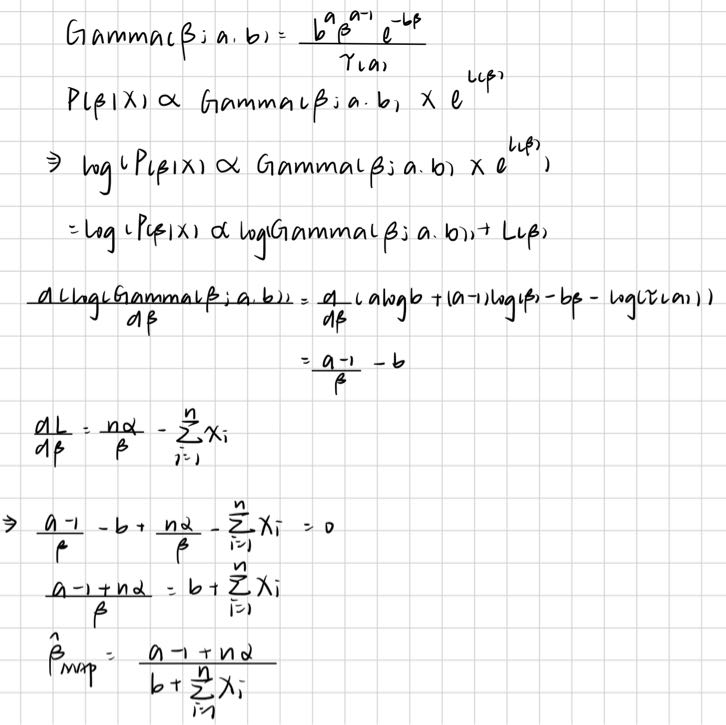

**7.1.20 Task:**<br/>
Write a small function that computes the MAP parameter estimate of $\beta$, based on the previously defined variable `alpha` and on the inputs `dataset`, `a`, and `b`. <font color="red">(0.25 Point)</font>

In [76]:
def beta_hat_map(dataset, a, b):
    # YOUR CODE HERE
    beta_map = (a - 1 + alpha * len(dataset)) / (b + np.sum(dataset))
    return beta_map

In [77]:
assert np.isclose(beta_hat_map(np.array([1, 2, 3]), 5, 2), 2.375, atol=1e-4)
assert np.isclose(beta_hat_map(np.array([7, 8, 10]), 2, 10), 0.45714, atol=1e-4)

**7.1.21 Task:**<br/>
Apply the MAP function that you just implemented to datasets A, B, and C for the prior parameters $a=5$, $b=1$. Plot the histograms and the ML-estimated density from before, but with the respective maximum a-posteriori estimated probability density function overlaid as a line plot. That is, each plot should contain a histogram and two gamma densities: one from MLE and the other based on the MAP parameter estimate. <font color="red">(0.25 Point)</font>

<ipython-input-67-f7e903026ea9>:22: RuntimeWarning: divide by zero encountered in log
  log_pdf = ((self.alpha - 1) * np.log(x) - self.beta * x - loggamma(self.alpha) + self.alpha * np.log(self.beta))


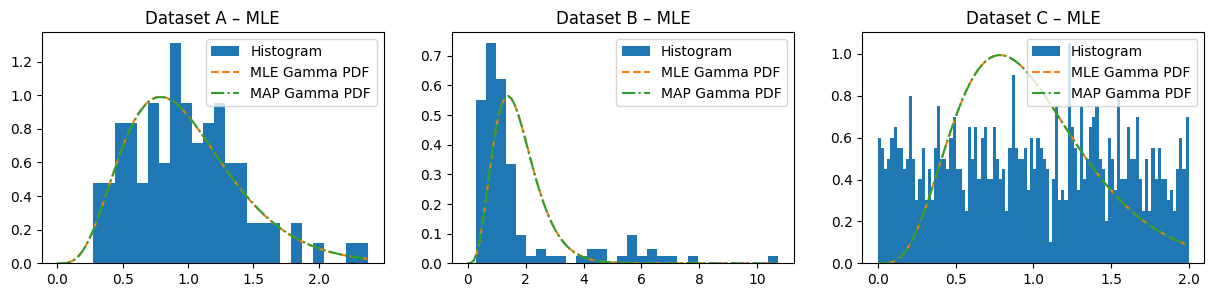

In [78]:
a, b = 5, 1

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

# Hint: Use the axes ax1, ax2 and ax3 for plotting
ax1.set_title('Dataset A – MLE')
# YOUR CODE HERE
beta_A_map = beta_hat_map(dataset['A'], a, b)
hist_values_A, bins_A, _ = ax1.hist(dataset['A'],num_bins_A, density=True, label='Histogram')
x_A = np.linspace(0, np.max(dataset['A']), 100)
kde_values_A = kde_pdf_a
#ax1.plot(x_A, kde_values_A, label='KDE')

gamma_pdf_A_mle = Gamma(alpha,beta_A_mle).pdf(x_A)
ax1.plot(x_A, gamma_pdf_A_mle, label='MLE Gamma PDF', linestyle='--')

gamma_pdf_A_map = Gamma(alpha,beta_A_map).pdf(x_A)
ax1.plot(x_A, gamma_pdf_A_map, label='MAP Gamma PDF', linestyle='-.')
ax1.legend()

ax2.set_title('Dataset B – MLE')
# YOUR CODE HERE
beta_B_map = beta_hat_map(dataset['B'], a, b)
hist_values_B, bins_B, _ = ax2.hist(dataset['B'], bins = num_bins_B, density=True, label='Histogram')
x_B = np.linspace(0, np.max(dataset['B']), 100)
kde_values_B = kde_pdf_b
#ax2.plot(x_B, kde_values_B, label='KDE')

gamma_pdf_B_mle = Gamma(alpha,beta_B_mle).pdf(x_B)
ax2.plot(x_B, gamma_pdf_B_mle, label='MLE Gamma PDF', linestyle='--')

gamma_pdf_B_map = Gamma(alpha,beta_B_map).pdf(x_B)
ax2.plot(x_B, gamma_pdf_B_map, label='MAP Gamma PDF', linestyle='-.')
ax2.legend()

ax3.set_title('Dataset C – MLE')
# YOUR CODE HERE
beta_C_map = beta_hat_map(dataset['C'], a, b)
hist_values_C, bins_C, _ = ax3.hist(dataset['C'], bins = num_bins_C, density=True, label='Histogram')
x_C = np.linspace(0, np.max(dataset['C']), 100)
kde_values_C = kde_pdf_c
#ax3.plot(x_C, kde_values_C, label='KDE')

gamma_pdf_C_mle = Gamma(alpha,beta_C_mle).pdf(x_C)
ax3.plot(x_C, gamma_pdf_C_mle, label='MLE Gamma PDF', linestyle='--')

gamma_pdf_C_map = Gamma(alpha,beta_C_map).pdf(x_C)
ax3.plot(x_C, gamma_pdf_C_map, label='MAP Gamma PDF', linestyle='-.')
ax3.legend()

plt.show()

**7.1.22 Task:**<br/>
Repeat the plots in the previous cell, but using $a=500$, $b=100$ for the prior instead. As you saw in a previous plot you made, this gives a very narrow prior centered on $\beta\approx5$. <font color="red">(0.5 Point)</font>

<ipython-input-67-f7e903026ea9>:22: RuntimeWarning: divide by zero encountered in log
  log_pdf = ((self.alpha - 1) * np.log(x) - self.beta * x - loggamma(self.alpha) + self.alpha * np.log(self.beta))


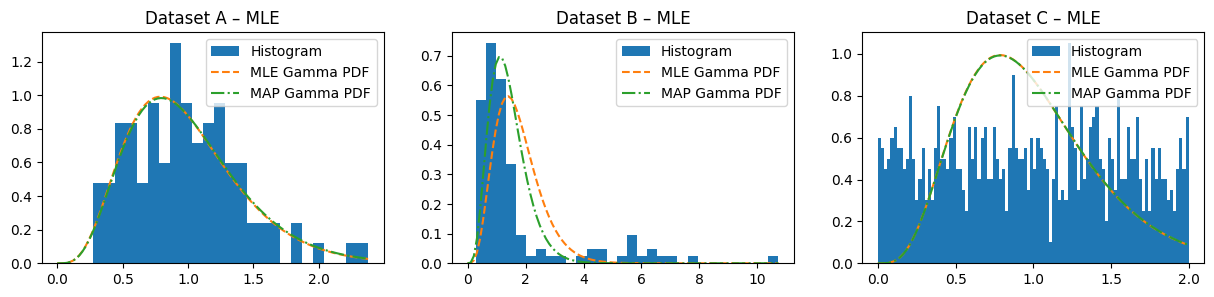

In [79]:
a, b = 500, 100

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

# Hint: Use the axes ax1, ax2 and ax3 for plotting
ax1.set_title('Dataset A – MLE')
# YOUR CODE HERE
beta_A_map = beta_hat_map(dataset['A'], a, b)
hist_values_A, bins_A, _ = ax1.hist(dataset['A'],num_bins_A, density=True, label='Histogram')
x_A = np.linspace(0, np.max(dataset['A']), 100)
kde_values_A = kde_pdf_a
#ax1.plot(x_A, kde_values_A, label='KDE')

gamma_pdf_A_mle = Gamma(alpha,beta_A_mle).pdf(x_A)
ax1.plot(x_A, gamma_pdf_A_mle, label='MLE Gamma PDF', linestyle='--')

gamma_pdf_A_map = Gamma(alpha,beta_A_map).pdf(x_A)
ax1.plot(x_A, gamma_pdf_A_map, label='MAP Gamma PDF', linestyle='-.')
ax1.legend()

ax2.set_title('Dataset B – MLE')
# YOUR CODE HERE
beta_B_map = beta_hat_map(dataset['B'], a, b)
hist_values_B, bins_B, _ = ax2.hist(dataset['B'], bins = num_bins_B, density=True, label='Histogram')
x_B = np.linspace(0, np.max(dataset['B']), 100)
kde_values_B = kde_pdf_b
#ax2.plot(x_B, kde_values_B, label='KDE')

gamma_pdf_B_mle = Gamma(alpha,beta_B_mle).pdf(x_B)
ax2.plot(x_B, gamma_pdf_B_mle, label='MLE Gamma PDF', linestyle='--')

gamma_pdf_B_map = Gamma(alpha,beta_B_map).pdf(x_B)
ax2.plot(x_B, gamma_pdf_B_map, label='MAP Gamma PDF', linestyle='-.')
ax2.legend()

ax3.set_title('Dataset C – MLE')
# YOUR CODE HERE
beta_C_map = beta_hat_map(dataset['C'], a, b)
hist_values_C, bins_C, _ = ax3.hist(dataset['C'], bins = num_bins_C, density=True, label='Histogram')
x_C = np.linspace(0, np.max(dataset['C']), 100)
kde_values_C = kde_pdf_c
#ax3.plot(x_C, kde_values_C, label='KDE')

gamma_pdf_C_mle = Gamma(alpha,beta_C_mle).pdf(x_C)
ax3.plot(x_C, gamma_pdf_C_mle, label='MLE Gamma PDF', linestyle='--')

gamma_pdf_C_map = Gamma(alpha,beta_C_map).pdf(x_C)
ax3.plot(x_C, gamma_pdf_C_map, label='MAP Gamma PDF', linestyle='-.')
ax3.legend()

plt.show()

**7.1.23 Question:**<br/>
Comment on the effect of a wide versus a narrow prior on $\boldsymbol\beta$. In what case does $\widehat{\beta}_{\mathrm{MAP}}$ deviate notably from $\widehat{\beta}_{\mathrm{ML}}$? Why are the estimates different in this case? When could an ability to constrain the parameter estimates like this be useful? <font color="red">(1 Point)</font>

YOUR ANSWER HERE

For wide prior, when the values of a and b are larger, the peak value of the prior distribution will be closer to 0, and beta_map will be closer to beta_ml.When the values of a and b are small, the peak value of the prior distribution will be further away from 0, and there will be a deviation between beta_map and beta_ml.Narrow priors can be used when the data are incomplete or to reduce overfitting. When data are very limited, estimates with strong priors can provide useful information to help better estimate parameters. At the same time, narrow priors can reduce the risk of overfitting and make the model more robust.

## 7.2 A two-dimensional problem (5.5 points)

In this part of the exercise, we will work on a small, two-dimensional toy dataset. You will implement the formulas for EM parameter estimation with a GMM in two dimensions, and then use this to train (fit) a few GMMs to the dataset. When you do this, you will run into some... interesting issues, and learn a very useful trick for making mixture models work well in practice.

### Loading and visualising the data

We begin by loading the dataset. (A test set is included, but not currently used.)

In [80]:
dataset = data['part_2']

X_train = np.array(dataset['X_train'])

To get an idea of what this data is like, we print the shape of the training and test sets and visualise the data using a 2D scatterplot.

Dataset shape:	 (100, 2)


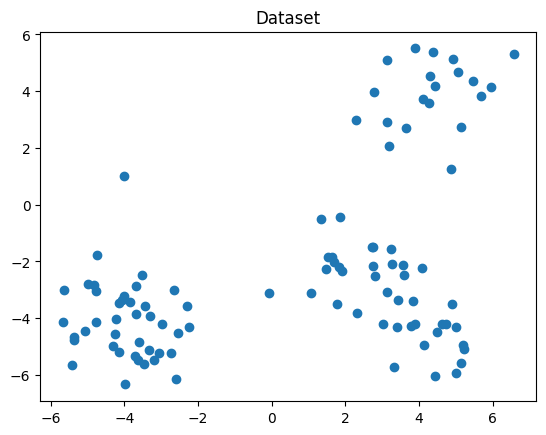

In [81]:
# Printing the shapes
print(f"Dataset shape:\t {X_train.shape}")

# Visualizing the data
fig, ax = plt.subplots()
ax.scatter(X_train[:, 0], X_train[:, 1])
ax.set_title('Dataset')
plt.show()

You will now implement the update equations for an _axis-aligned_ GMM. “Axis-aligned” means that the covariance matrix of each component Gaussian is diagonal (i.e., the two dimensions are uncorrelated), which simplifies the mathematics. (Recall that, for a diagonal covariance matrix, parameter estimates can be computed independently for each dimension.)

In [82]:
# These are helper functions. Please don't make any changes to these.

def make_array(x):
    if not isinstance(x, np.ndarray):
            x = np.array(x)
    return x

def generate_data_space(grid_region_min=-8, grid_region_max=8):
    x = np.linspace(grid_region_min, grid_region_max, 500)
    y = np.linspace(grid_region_min, grid_region_max, 500)
    xx, yy = np.meshgrid(x, y)
    pos = np.dstack((xx, yy))
    return x, y, xx, yy, pos

### The E-step

The first thing you will do is to implement the log probability density function $\ln \mathcal{N}_{\boldsymbol x}(x;\mu, \mathrm{diag}(\sigma)^2)$ of a multivariate Gaussian distribution with mean $\mu$ and a diagonal covariance matrix $\mathrm{diag}(\sigma)^2$. This function has two inputs:
* One or more observations `x` of shape `(n_obs, n_dim)`, where `n_obs > 0` is the number of observations $x_i$ and `n_dim > 0` is the number of elements in each vector $x_i$. This is the same format as that used by `X_train` above.
* Model parameters `mu` and `sigma`, both of shape `(n_dim)`, which contain a mean $\mu_d$ and a standard deviation $\sigma_d$ for each dimension.

The function should return one output:
* `log_gauss_pdf` of shape `(n_obs)`, containing the logarithm of the Gaussian pdf evaluated at each observation in `x`.


**7.2.1 Task:**<br/>
Implement the function `log_gauss_pdf` according to the above specification. <font color="red">(1 Point)</font>

_Remark:_<br/>
Please make your code work for any dimensionality of the $x$-vectors, even though we will have `n_dim=2` for the data considered later in this part.

_Hint:_<br/>
For a diagonal covariance matrix, as here, the contribution to the log-probability due to each dimension $d$ can be compluted independently, and then summed. More explicitly, the probability density function of a Gaussian with a diagonal covariance matrix can be written

$$ \mathcal{N}_{\boldsymbol x}(x;\mu, \mathrm{diag}(\sigma)^2) =  (\sqrt{2\pi})^{-D} \prod_{d=1}^D \dfrac{1}{\sigma_d} \exp \left( -\dfrac{(x_d - \mu_d)^2}{2\sigma_d^2} \right) \text{,}$$

where $\sigma_d^2$ is the $d$th element of the diagonal covariance matrix. Also, keep in mind that the standard deviation $\sigma$ is not the same thing as the variance $\sigma^2$. We have added a few test cases below to guide you. If any bugs remain, there is another opportunity to catch them when you run the complete EM-algorithm to train GMMs later on. If you want to read more, additional information about Gaussians with diagonal covariance matrices can be found here: https://markusthill.github.io/gaussian-distribution-with-a-diagonal-covariance-matrix/

_Important:_<br/>
Do all computations in the logarithmic domain! If you first compute $\mathcal{N}_{\boldsymbol x}(x;\mu, \mathrm{diag}(\sigma)^2)$ and then take the logarithm, you will lose a lot of numerical precision and training _will_ fail!

In [83]:
def log_gauss_pdf(x, mu, sigma):
    x, mu, sigma = make_array(x), make_array(mu), make_array(sigma)

    assert len(x.shape) > 1, f"The input should be in shape of (n_obs, n_dim). {x.shape} passed."

    # YOUR CODE HERE
    log_pdf = -0.5 * x.shape[1] * np.log(2 * np.pi) - np.sum(np.log(sigma))- 0.5 * np.sum(((x - mu) / sigma) ** 2, axis=-1)
    return log_pdf

In [84]:
assert np.isclose(np.exp(log_gauss_pdf(x=[[0.2, 1.2]], mu=[0, 1], sigma=[1, 1])), np.array([0.1529]), atol=1e-4), "The value is incorrect check the formula again"
assert np.isclose(log_gauss_pdf(x=[[0.2, 1.2], [-0.2, 0.8]], mu=[0, 1], sigma=[1, 1]),  np.array([-1.8778, -1.8778]), atol=1e-4).all(), "The value is incorrect check the formula again"

Once you have access to the density function $\mathcal{N}_{\boldsymbol x}(x;\mu, \mathrm{diag}(\sigma^2))$ of a single multivariate, axis-aligned Gaussian (or, as here, its logarithm), it's quite easy to implement the E-step of the EM-algorithm. All that needs to be done is to compute the probability of each datapoint having come from the each component, under the current model $\theta=\{\pi_j,\mu^{(j)},\sigma^{(j)}\}_{j=1}^m$.

The E-step of the EM algorithm takes data and model parameters as input and computes the responsibilities. It has two inputs:
* The training-data observations `x` of shape `(n_obs, n_dim)`.
* The parameters $\theta$ of the GMM, comprising `weights` of shape `(n_components)` and `mus` and `sigmas` of shape `(n_components, n_dim)`, i.e., one $\mu$-vector and one $\sigma$-vector for each component $j$.

The E-step returns two outputs:
* `gammas` of shape `(n_obs, n_components)`, containing the responsibilities $\gamma_{ij}(\theta):=P_{\pmb z|\pmb x}(j|x_i;\theta)$, i.e., the conditional probability that component $j$ was responsible for observation $x_i$, according to the current model parameters.
* `log_likelihood` of shape `(n_obs)`, which contains the. This output is not strictly necessary, but only included for convenience, since it is easy to compute the log likelihood of the current model as a side product when computing the responsibilities.

To make things easier, _we have already implemented the E-step for you._ You do not need to do that. You should, however, study the code so that you understand what is going on.

In [85]:
# The e_step function has already implemented, for your convenience.

def e_step(x, weights, mus, sigmas):
    x, weights, mus, sigmas = make_array(x), make_array(weights), make_array(mus), make_array(sigmas)

    n_components = weights.shape[0]
    log_responsibilities = np.zeros((x.shape[0], n_components))
    for j in range(n_components):
        log_responsibilities[:, j] = np.log(weights[j]) + log_gauss_pdf(x, mus[j], sigmas[j])

    log_likelihood = logsumexp(log_responsibilities, axis=1)
    log_responsibilities = log_responsibilities - log_likelihood[:, np.newaxis]

    return np.exp(log_responsibilities), log_likelihood

**7.2.2 Question:**<br/>
Why does the code use a special SciPy function to compute the following line
```python
log_likelihood = logsumexp(log_responsibilities, axis=1)
```
and not the more straightforward solution
```python
log_likelihood = np.log(np.exp(log_responsibilities).sum(axis=1))
```
? Give one to three sentences of motivation.

_Hint:_<br/>
There is a functional difference; it's not merely that the former line is shorter to type. <font color="red">(1 Point)</font>

YOUR ANSWER HERE

When the log probability gets really small (appropriately below -700) or big, converting it back to probability causes underflow/overflow.  The logsumexp" function handles large or small log probability values with log-sum-exp tricks.This enhances computational stability and reliability when dealing with log probabilities.

### The M-step

The M-step of the EM algorithm uses the responsibilities (and the data) to compute updated parameter estimates $\theta^{\mathrm{new}}$. It has two inputs:
* The training-data observations `x` of shape `(n_obs, n_dim)`.
* The responsibilities `gammas`, of shape `(n_obs, n_components)`, representing the probabilities $\gamma_{ij}(\theta)$ that each observation $x_i$ was generated by the component $\mathcal{N}(x;\mu^{(j)}, \mathrm{diag}(\sigma^{(j)})^2)$.

The M-step should return three outputs, as a single tuple:
* `(weights, mus, sigmas)` containing updated parameter estimates $\widehat\theta^{\mathrm{new}}$. Specifically, `weights` has shape `(n_components)` while `mus` and `sigmas` have shape `(n_components, n_dim)`, i.e., one $\mu$-vector and one $\sigma$-vector for each component $j$.

**7.2.3 Task:**<br/>
Implement the function `m_step` according to the above specification. The code should work for `n_components > 0`, including `ncomponents == 1`. <font color="red">(2 Point)</font>

_Hint:_<br/>
The lecture notes have formulas for the general case, where the covariance matrix $\Sigma^{(j)}$ is a full matrix. In this exercise, however, we are working with covariance matrices that are restricted to be diagonal, $\Sigma^{(j)}=\mathrm{diag}((\widehat\sigma^{(j)})^2)$. Since we are working with Gaussian distributions, this means that each dimension is independent of each other dimension. For this reason, one can apply the one-dimensional version of the update formula for the covariance in the lecture notes to compute the variances $(\widehat\sigma^{(j)})^2$ for each dimension (each element in the $\widehat\sigma^{(j)}$-vector) separately.

_Hint:_<br/>
If implemented correctly, `weights > 0` and `np.sum(weights) == 1`, the new mean estimates `mus` should always lie within the convex hull of the datapoints, and `sigma > 0`.

_Hint:_<br/>
We have added a few test cases below to guide you. If any bugs remain, there is another opportunity to catch them when you run the complete EM-algorithm to train GMMs later on.

In [86]:
def m_step(x, gammas, **kwargs):
    # YOUR CODE HERE
    weights = np.sum(gammas, axis=0) / x.shape[0]
    mus = np.dot(gammas.T, x) / np.sum(gammas, axis=0)[:, np.newaxis]
    sigmas = np.zeros((gammas.shape[1], x.shape[1]))
    for j in range(gammas.shape[1]):
        for d in range(x.shape[1]):
            sigmas[j, d] = np.sqrt(np.sum(gammas[:, j] * (x[:, d] - mus[j, d]) ** 2) / np.sum(gammas[:, j]))

    return weights, mus, sigmas


In [87]:
test_ws, test_mus, test_sigmas = m_step(np.array([[0, 1], [1, 0]]), np.array([[1], [2]]))
assert np.isclose(test_ws, np.array([1.5]), atol=1e-4), "Incorrect implementation. Check the formulas again"
assert np.isclose(test_mus, np.array([[0.6666, 0.3333]]), atol=1e-4).all(), "Incorrect implementation. Check the formulas again"
assert np.isclose(test_sigmas, np.array([[0.47140452, 0.47140452]]), atol=1e-4).all(), "Incorrect implementation. Check the formulas again"


test_ws, test_mus, test_sigmas = m_step(np.array([[0, 1], [1, 0]]), np.array([[0.5, 0.5], [0.2, 0.8]]))

assert np.isclose(test_ws, np.array([0.35, 0.65]), atol=1e-4).all(), "Incorrect implementation. Check the formulas again"
assert np.isclose(test_mus, np.array([[0.2857, 0.7142], [0.6153, 0.3846]]), atol=1e-4).all(), "Incorrect implementation. Check the formulas again"
assert np.isclose(test_sigmas, np.array([[0.4517, 0.4517], [0.4865, 0.4865]]), atol=1e-4).all(), "Incorrect implementation. Check the formulas again"


### Initialisation and training loop

For initialisation, we'll use a simple recipe to come up with inital parameters $\theta_0$. Specifically, we just pick `n_components` observations at random from `x` and use these for the means `mus`. The weights are initialised to represent a uniform distribution, while the standard deviations `sigma[:, d]` are proportional to the standard deviation of data in dimension `d`.

In [88]:
def init_gmm(x, n_components):

    global RANDOM_SEED

    n, n_dim = x.shape
    np.random.seed(RANDOM_SEED) # resetting the seed

    # Init mu from the datapoints
    mus_indices = np.random.choice(n, n_components, replace=False)
    mus = x[mus_indices]

    # Uniform weights
    weights = np.full(n_components, 1/n_components)

    # Standard deviation from the standard deviation of data scaled by the numer of components
    component_std = x.std(axis=0)
    sigmas = np.full((n_components, n_dim), component_std / np.sqrt(n_components))

    return (weights, mus, sigmas)

Training begins by calling the initialisation routine. The main training loop then performs alternating E-steps and M-steps until a specified number of iterations `n_iter` is reached. Our training loop also includes code to compute and display the evolution of the negative log-likelihood, and code to visualise the data and the GMM during training. You can use the `pause` argument to control the amount of time (in seconds) to pause between each iteration, to adjust the speed of the animation.

In [89]:
def train_gmm(x, weights, mus, sigmas, n_iter=30, pause=0.5, **kwargs):

    neg_log_likelihood = []
    for i in range(n_iter+1):

        # 1) Plot GMM
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        plt.suptitle(f"Iteration: {i}")

        x_axis, y_axis, xx, yy, pos = generate_data_space()

        # Compute GMM pdf for heatmap
        gmm_pdf = np.zeros(np.shape(pos)[:-1])
        for j in range(weights.shape[0]):
            weight, mu, sigma = weights[j],  mus[j], sigmas[j]
            gmm_pdf = gmm_pdf + np.exp(log_gauss_pdf(pos, mu, sigma)) * weight
            #ax[0].contour(xx, yy, z)
        ax[0].contourf(xx, yy, np.minimum(gmm_pdf, 0.1), cmap="Greys") # Plot clipped heatmap
        ax[0].scatter(x[:, 0], x[:, 1])

        for j in range(weights.shape[0]):
            weight, mu, sigma = weights[j],  mus[j], sigmas[j]
            ax[0].plot([mu[0]-sigma[0], mu[0]+sigma[0]], [mu[1], mu[1]], 'r-')
            ax[0].plot([mu[0], mu[0]], [mu[1]-sigma[1], mu[1]+sigma[1]], 'r-')
            #component_ellipse = plt.patches.Ellipse(mu, width=2*sigma[0], height=2*sigma[1])
            #ax.add_patch(component_ellipse)

        ax[0].set_xlabel('x1')
        ax[0].set_ylabel('x2')
        ax[0].set_title('GMM')

        # 2) Run E step
        gammas, log_likelihood = e_step(x, weights, mus, sigmas)
        mean_neg_log_likelihood = -log_likelihood.mean()

        # 3) Plot and print NLL
        neg_log_likelihood.append(mean_neg_log_likelihood)
        ax[1].plot(neg_log_likelihood)
        ax[1].set_title("Negative log likelihood")
        ax[1].set_xlabel('iterations')
        display.clear_output(wait=True)
        display.display(plt.gcf()) # Display all plots

        if np.isnan(log_likelihood).any():
            print(f"Weights: {weights}")
            print(f"Mus: {mus}")
            print(f"Sigma: {sigmas}")
            plt.close(fig)
            raise ValueError(f"Negative log likelihood is NaN in this iteration: {mean_neg_log_likelihood}")

        print(f"Negative log likelihood per datapoint: {mean_neg_log_likelihood: .5f}")

        if i < n_iter: # Only update parameters if we are not in the last step of the loop
            #prev_thetas = weights, mus, sigmas
            weights, mus, sigmas = m_step(x, gammas, **kwargs)

            time.sleep(pause)

        plt.close(fig)


    return (weights, mus, sigmas), neg_log_likelihood

### Train GMMs on the data

The big moment has arrived! Let's try to train a few GMMs to verify that it works and see how GMM training works.

**Task:**<br/>
Initialise a GMM using `init_gmm`. Then run the command `train_gmm(x, weights, mus, sigmas, n_iter)` to train a GMM on the data for `n_iter=30` iterations. The command returns a tuple representing $\widehat\theta_{\mathrm{ML}}$. Do this for ` 0 < n_components < 6`.

During training the command will display an animated visualisation:
* The window on the left shows the training curve, tracking how the negative log-likelihood $-\ln p_{\mathcal{X}}(\mathcal{D},\widehat{\theta}_u)$ evolves with each training update $u$.
* The window on the right shows a scatterplot of the data. Each component centre $\widehat{\mu}^{(j)}$ is marked by a cross, whose width and height is equal to the standard deviation $\widehat{\sigma}^{(j)}$ in each direction. The overall probability density of the GMM is visualised as a greyscale heatmap.

_Hint:_<br/>
This is a good opportunity to test your implementation! If everything is correct, there should be no errors/exceptions and training should converge without the log-likelihood ever decreasing. If that is not the case, there is very likely a mistake in `log_gauss_pdf`, `e_step`, or `m_step`, so go back and test your implementation of those functions more.

_Important:_<br/>
Keep the random seed and the number of iterations at the specified value, to ensure that you get consistent results.

_Note:_<br/>
This part is not worth any points, since the idea is just to let you test that your implementation works and to learn how it behaves.

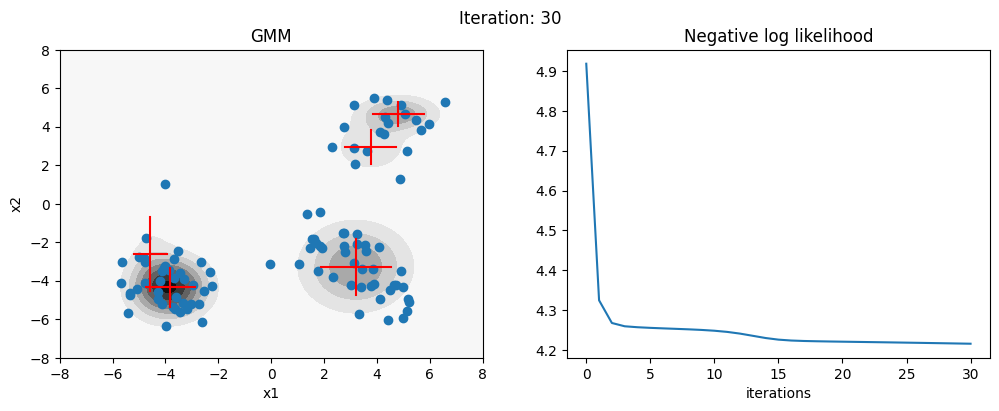

Negative log likelihood per datapoint:  4.21532
number of components 5
weights :  [0.40077521 0.08645497 0.05969938 0.34033047 0.11273997]
means :  [[ 3.20113642 -3.26763377]
 [ 3.76587195  2.93753006]
 [-4.57665056 -2.61647697]
 [-3.81780871 -4.34774039]
 [ 4.81222778  4.66479937]]
signmas :  [[1.32307922 1.45630716]
 [0.96288861 0.88698773]
 [0.6268077  1.9295311 ]
 [0.92277626 1.00463183]
 [0.97567373 0.60765273]]


In [90]:
# YOUR CODE HERE
for n_components in range(1, 6):
    weights, mus, sigmas = init_gmm(X_train, n_components)
    trained_params, neg_log_likelihood = train_gmm(X_train, weights, mus, sigmas, n_iter=30)
    print('number of components', n_components)
    print('weights : ', trained_params[0])
    print('means : ', trained_params[1])
    print('signmas : ', trained_params[2])


Let's see what happens when training a GMM with $m=10$ components on the data. That should work now, right?

_Hint:_<br/>
Keep an eye on what happens to the component in the top left quadrant. Move on to the next cell even if you get an error.

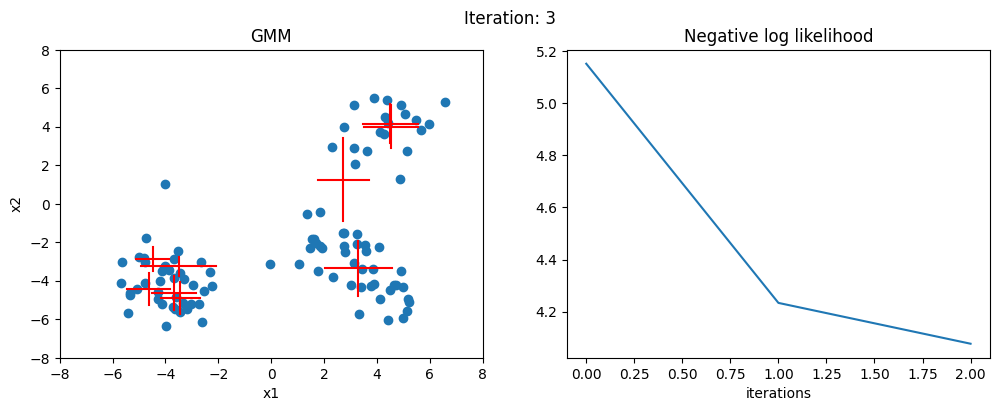

Weights: [0.37898444 0.08606213 0.07649177 0.09308694 0.08739263 0.01
 0.06541395 0.11044953 0.0422395  0.04987911]
Mus: [[ 3.29710932 -3.36153878]
 [ 4.54920702  4.01034622]
 [-4.63028923 -4.43042053]
 [-3.43583171 -4.89235104]
 [ 4.5169213   4.15189821]
 [-4.          1.        ]
 [-3.49712714 -3.26106532]
 [-3.67746729 -4.63810011]
 [ 2.72992222  1.25030354]
 [-4.48430567 -2.85709774]]
Sigma: [[1.26939605 1.4153645 ]
 [1.0239054  1.1098046 ]
 [0.80735558 0.81917376]
 [0.73417006 0.83606144]
 [1.03609165 1.0078713 ]
 [0.         0.        ]
 [1.41657876 0.49995513]
 [0.83883343 0.89409631]
 [0.95877199 2.13918991]
 [0.63435351 0.63464003]]


ValueError: ignored

In [91]:
n_components = 10
n_iter = 30

initial_theta = init_gmm(X_train, n_components)

trained_theta, training_curve = train_gmm(X_train, *initial_theta, n_iter, pause=1.5)

That's weird! The log-likelihood seems to be taking off towards infinity, and then training breaks down with some kind of error?

This error is not on you, but actually reflects a classic problem that tends to occur when applying GMMs in practice. (If you didn't get an error, something is not according to expectations, but check out if you get an error when you run the next code cell below.)

If you didn't already spot what went wrong above, let's dissect the situation using a more obvious example.

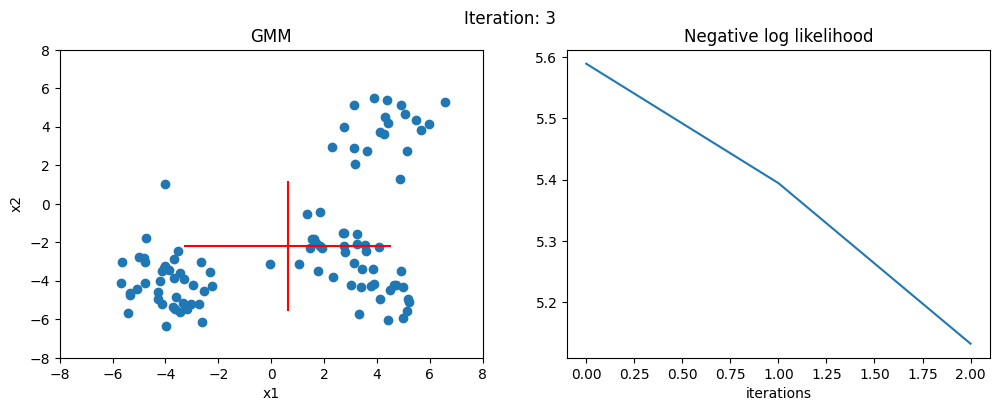

Weights: [0.99 0.01]
Mus: [[ 0.62475263 -2.19755934]
 [-4.          1.        ]]
Sigma: [[3.86784201 3.34163464]
 [0.         0.        ]]


ValueError: ignored

In [92]:
initial_weights = np.array([0.995, 0.005])
initial_mus = np.array([[0, 0], [-4, 1]]) # The second component sits on top of the outlying pooint
initial_sigmas = np.array([[4, 4], [1, 1]]) # The second component is quite narrow

initial_theta = initial_weights, initial_mus, initial_sigmas

trained_theta, training_curve = train_gmm(X_train, *initial_theta, n_iter=n_iter, pause=1.5)

**7.2.4 Question:**<br/>
What happens to the standard deviation of the second component as training progresses? Why does this cause numerical problems? Give a clear explanation based on the mathematical expression for the Gaussian pdf. <font color="red">(1 Point) </font>

YOUR ANSWER HERE

The error is 'Negative log likelihood is NaN in this iteration: nan'.

The error message "Negative log likelihood is NaN" occurs in the EM algorithm for Gaussian Mixture Models (GMMs) when one of the components in the mixture has a singular covariance matrix, leading to an infinite probability density. This happens because a singular covariance matrix implies that the data points for that component are perfectly aligned along one or more axes, resulting in an exponential term with an infinitely large value. In practical computational implementations, this can lead to numerical instability, and the software often returns NaN or raises errors to signal such issues in the calculations.


### Fixing the problem using variance flooring

The above error shows that the likelihood of the data actually is _unbounded_. This is not because the model is infinitely good, which should be intuitive from watching the animation, or from calculating the log-likelihood on validation data. Instead, it's because the model is so flexible that it can find _degenerate solutions_, which are bad edge cases that achieve arbitrarily high likelihoods.

Degenerate edge cases exist for _any_ GMM with $m>1$. In fact, every time the standard update formulas settle on a reasonable model and without breaking down, what's really happening is you were rescued from the degeneracies by getting stuck in a local optimum that is not globally optimal. Who knew that local optima sometimes could be a good thing?

Degenerate situations pop in lots of different areas of machine learning, both probabilistic and not. I like to think of degeneracies as _specification errors_: we are telling the the machine to optimise a certain number, but we didn't realise that there are solutions to the optimisation problem we formulated that have good values for the objective function, but that are bad in real life. It's a mismatch between what we tell the computer that we want, and what we actually want.

To solve the specification error, we need to revise our problem formulation: what kind of solutions that we look for and/or how we find them.

Let's return to the situation at hand. This time, the real problem with the GMM is not with the code. Instead, the issue is that the parametric family contains degenerate distributions where the probability density is unbounded. We get close to these degenerate distributions when any $\sigma$-value in the model gets small.

There are many ways to fix this issue, but a widely-used technique called _variance flooring_ is to simply prohibit the $\sigma$-values from approaching zero small. The way to do so in practice is very simple: At the end of every M-step, check that all elements of `sigma` are greater or equal to a `sigma_min` argument. Any elements of `sigma` that violate this criterion are just set equal to `sigma_min`! `sigma_min**2` thus acts as a “floor” that imposes a lowest-permitted value for the variance.

The above might sound like a bit of a hack, but there is a nice theoretical implementation: what we are doing is redefine that we are redefining the parametric family that we are optimising over. Specifically, we remove models within a certain neighbourhood of degenerate parameter values, and only optimise over (now constrained) set of parameters $\{\theta:\sigma_d^{(j)}\geq\sigma_{\mathrm{min}}\forall j,d\}$. The act of setting elements $\sigma_d^{(j)}$ that violate the constraint to $\sigma_{\mathrm{min}}$ can be seen as a projection on this feasible set.

**8.2.5 Task:**<br/>
Re-implement the `m_step` function to incorporate variance flooring. The minimum-permitted standard-deviation value is controlled via the new `sigma_min` argument. <font color="red">(0.5 Point) </font>

In [93]:
def m_step(x, gammas, sigma_min):
    weights = np.sum(gammas, axis=0) / x.shape[0]
    mus = np.dot(gammas.T, x) / np.sum(gammas, axis=0)[:, np.newaxis]
    sigmas = np.zeros((gammas.shape[1], x.shape[1]))
    for j in range(gammas.shape[1]):
        for d in range(x.shape[1]):
            sigma_d = np.sqrt(np.sum(gammas[:, j] * (x[:, d] - mus[j, d]) ** 2) / np.sum(gammas[:, j]))
            # Apply variance flooring
            if sigma_d < sigma_min:
                sigma_d = sigma_min
            sigmas[j, d] = sigma_d

    return weights, mus, sigmas

In [94]:
test_ws, test_mus, test_sigmas = m_step(np.array([[0, 1], [1, 1]]), np.array([[0.9, 0.1], [0.1, 0.9]]), 0.3)
assert np.isclose(test_ws, np.array([0.5, 0.5]), atol=1e-4).all(), "Incorrect implementation. Check the formulas again"
assert np.isclose(test_mus, np.array([[0.1, 1.0], [0.9, 1.0]]), atol=1e-4).all(), "Incorrect implementation. Check the formulas again"
assert np.isclose(test_sigmas, np.array([[0.3, 0.3], [0.3, 0.3]]), atol=1e-4).all(), f"Variance flooring not implemented one of the sigmas is less than the floor value of 0.3 passed. sigmas: {test_sigmas}"

Now let's run a few tests to check that this fixes the problem!

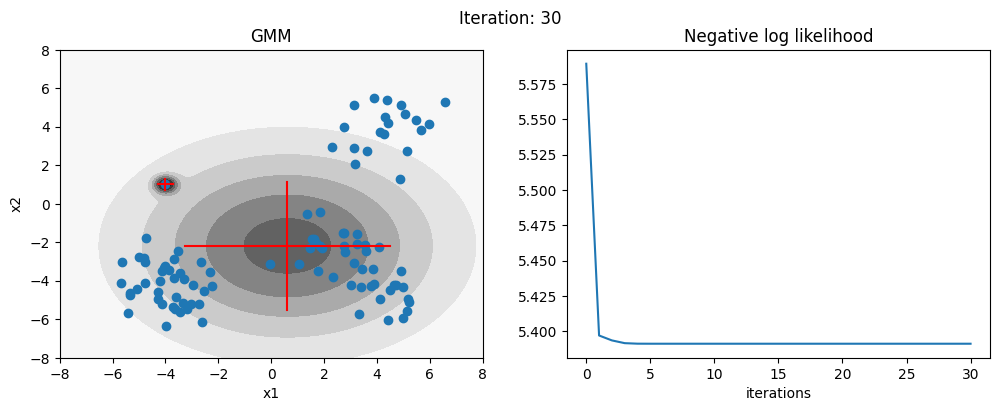

Negative log likelihood per datapoint:  5.39122


In [95]:
sigma_min = 0.3

# This setup previously gave an error
initial_weights = np.array([0.995, 0.005])
initial_mus = np.array([[0, 0], [-4, 1]]) # The second component sits on top of the outlying pooint
initial_sigmas = np.array([[4, 4], [1, 1]]) # The second component is quite narrow

initial_theta = initial_weights, initial_mus, initial_sigmas

trained_theta, training_curve = train_gmm(X_train, *initial_theta, n_iter=n_iter, sigma_min=sigma_min)

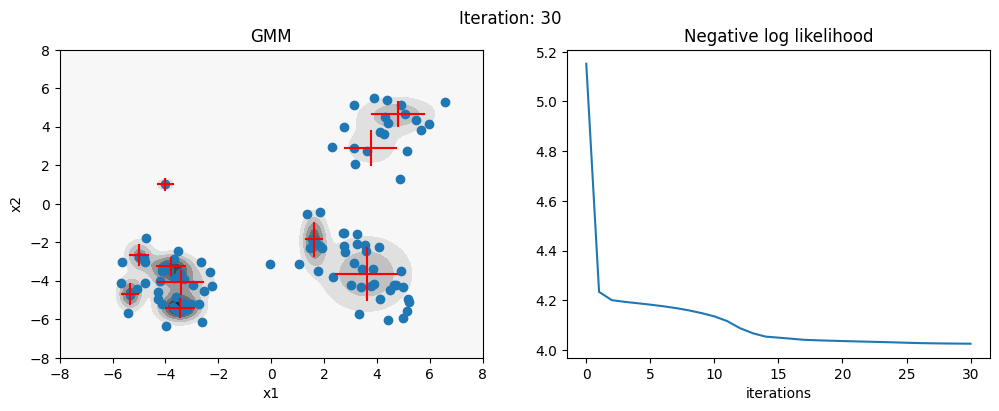

Negative log likelihood per datapoint:  4.02497
Trained weights: [0.31702071 0.08626301 0.05070965 0.11031861 0.11361003 0.01
 0.07689913 0.10846268 0.08294284 0.04377334]
Trained mus: [[ 3.61102084 -3.64869455]
 [ 3.77151565  2.91289673]
 [-5.33907677 -4.69436683]
 [-3.45786783 -5.41665045]
 [ 4.80575889  4.66096661]
 [-4.          1.        ]
 [-3.77754494 -3.2524523 ]
 [-3.42172165 -4.08905143]
 [ 1.62749576 -1.8492396 ]
 [-4.99729241 -2.6744891 ]]
Trained sigmas: [[1.17135574 1.32946715]
 [0.96444024 0.8879861 ]
 [0.3        0.5401573 ]
 [0.51963144 0.46161673]
 [0.97763571 0.60932118]
 [0.3        0.3       ]
 [0.52886235 0.44482573]
 [0.85751549 0.60259154]
 [0.3        0.86490872]
 [0.35220608 0.51894718]]


In [96]:
n_components = 10 # This previously gave an error
n_iter = 30
sigma_min = 0.3

initial_theta = init_gmm(X_train, n_components)

trained_theta, training_curve = train_gmm(X_train, *initial_theta, n_iter, sigma_min=sigma_min)

trained_weights, trained_mus, trained_sigmas = trained_theta

print("Trained weights: " + str(trained_weights))
print("Trained mus: " + str(trained_mus))
print("Trained sigmas: " + str(trained_sigmas))

Hooray! Problem solved!

But it should be noted that variance flooring isn't the only way to fix this problem. If you recall how we were able to use use prior distributions to constrain the parameter estimates on the 1D problem, the same approach can also be used here. There are, in fact, elegant Bayesian versions of the EM-algorithm for, e.g., GMMs, that you might see in future courses, but we will not go into those here.

### Take-home message

Variance flooring is a common fix/regulariser in many classic probabilistic models. It illustrates some failure modes that are particularly common in probabilistic modelling, namely loss/lack of numerical precision and degenerate optima.

That's not to say deep learning can't face these issues too. As an example, the combination of cross-entropy loss and softmax layers (used in the vast majority of neural-network-based classifiers) is likely to lead to loss of numerical precision, which is why we have a special command `torch.nn.BCEWithLogitsLoss` in PyTorch that combines the two in a numerically safe way. And one reason that deep neural network training is less likely to lead to degeneracies might be that neural nets are _harder_ to optimise well, which makes it more unlikely that the optimiser will find those points where the objective function attains extreme values due to degenerate optima!

However, theres also a wider story. The cycle of problem and solution that you saw here is a good example of a common pattern for how many different machine-learning methods behave in practice:
1. There's a beautiful theoretical formulation of how machine learning is supposed to work.
2. Once we apply the theory, it turns out that it doesn't always work reliably in applications, at least not straight off the bat.
3. To make methods work consistently (and work well) in practice, people invent a few more-or-less hacky “tricks” to fix the issues.
4. While many of these tricks come start out as quick-and-dirty engineering fixes, made to prevent implementational issues arising deep within the code, some of them can be given a theoretical interpretation if we think about them a bit more.
5. Sometimes a machine-learning researcher will look at these supposed hacks and their theoretical interpretation, and use these as a stepping stone to develop a better theory of machine learning and/or the problem at hand.

This feedback loop between theory and practice is an important factor in driving the field of machine learning forwards.